In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os


In [120]:
# Show available input files
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Load fetal measurement data
df = pd.read_csv("/kaggle/input/fetal-head-measurements/fetal_head_measurements.csv")

/kaggle/input/biparietal-diameter-standard/Bipartial Diameter Standard.xlsx
/kaggle/input/fetal-head-measurements/fetal_head_measurements.csv
/kaggle/input/head-circumference-standards/Head Circumference Standards.xlsx
/kaggle/input/fetal-head-ultrasound-segmentation/Fetal_Head_Ultrasound/training/245_HC.png
/kaggle/input/fetal-head-ultrasound-segmentation/Fetal_Head_Ultrasound/training/531_HC.png
/kaggle/input/fetal-head-ultrasound-segmentation/Fetal_Head_Ultrasound/training/237_2HC_Annotation.png
/kaggle/input/fetal-head-ultrasound-segmentation/Fetal_Head_Ultrasound/training/933_HC_Annotation.png
/kaggle/input/fetal-head-ultrasound-segmentation/Fetal_Head_Ultrasound/training/862_HC_Annotation.png
/kaggle/input/fetal-head-ultrasound-segmentation/Fetal_Head_Ultrasound/training/244_HC_Annotation.png
/kaggle/input/fetal-head-ultrasound-segmentation/Fetal_Head_Ultrasound/training/259_HC_Annotation.png
/kaggle/input/fetal-head-ultrasound-segmentation/Fetal_Head_Ultrasound/training/691_HC_A

In [130]:
# Convert pixels to mm using ultrasound calibration
PIXEL_TO_MM = 0.1
df['HC_mm'] = df['HC'] * PIXEL_TO_MM
df['BPD_mm'] = df['BPD'] * PIXEL_TO_MM


In [131]:
# Calculate Gestational Age from BPD and HC
df['GA_BPD'] = 2.646 + 0.03290 * df['BPD_mm'] + 1.646 * np.log(df['BPD_mm'])
df['GA_HC'] = 3.183 + 0.01082 * df['HC_mm'] + 0.000059 * df['HC_mm']**2

In [132]:
# Remove implausible GA (optional but recommended)
df = df[(df['GA_BPD'] <= 42) & (df['GA_HC'] <= 42)]

In [133]:
# Load standard charts
hc_data = pd.read_excel('/kaggle/input/head-circumference-standards/Head Circumference Standards.xlsx')
bpd_data = pd.read_excel('/kaggle/input/biparietal-diameter-standard/Bipartial Diameter Standard.xlsx')


In [134]:
# Clean HC data
hc_data.columns = ['Gestational Age', '3rd Percentile', '5th Percentile', '10th Percentile', 
                   '50th Percentile', '90th Percentile', '95th Percentile', '97th Percentile']
hc_data = hc_data.dropna(subset=['Gestational Age'])
hc_data['Gestational Age'] = pd.to_numeric(hc_data['Gestational Age'], errors='coerce')
hc_data = hc_data.sort_values('Gestational Age')
hc_data.set_index('Gestational Age', inplace=True)
hc_data = hc_data.apply(pd.to_numeric, errors='coerce')

In [135]:
# Clean BPD data
bpd_data = bpd_data.drop(index=0)
bpd_data.columns = ['Gestational Age', '3rd Percentile', '5th Percentile', '10th Percentile',
                    '50th Percentile', '90th Percentile', '95th Percentile', '97th Percentile']
bpd_data['Gestational Age'] = pd.to_numeric(bpd_data['Gestational Age'], errors='coerce')
bpd_data = bpd_data.dropna(subset=['Gestational Age'])
bpd_data = bpd_data.sort_values('Gestational Age')
bpd_data.set_index('Gestational Age', inplace=True)
bpd_data = bpd_data.apply(pd.to_numeric, errors='coerce')


In [136]:
# Interpolate standard percentiles for each subject's estimated GA
for col in bpd_data.columns:
    df[f'BPD_{col}'] = np.interp(df['GA_BPD'], bpd_data.index.values, bpd_data[col].values)

for col in hc_data.columns:
    df[f'HC_{col}'] = np.interp(df['GA_HC'], hc_data.index.values, hc_data[col].values)


In [137]:
# (Optional) Flag potential outliers
df['BPD_flag'] = np.where(df['BPD_mm'] < df['BPD_5th Percentile'], 'Below 5th',
                  np.where(df['BPD_mm'] > df['BPD_95th Percentile'], 'Above 95th', 'Normal'))

df['HC_flag'] = np.where(df['HC_mm'] < df['HC_5th Percentile'], 'Below 5th',
                 np.where(df['HC_mm'] > df['HC_95th Percentile'], 'Above 95th', 'Normal'))


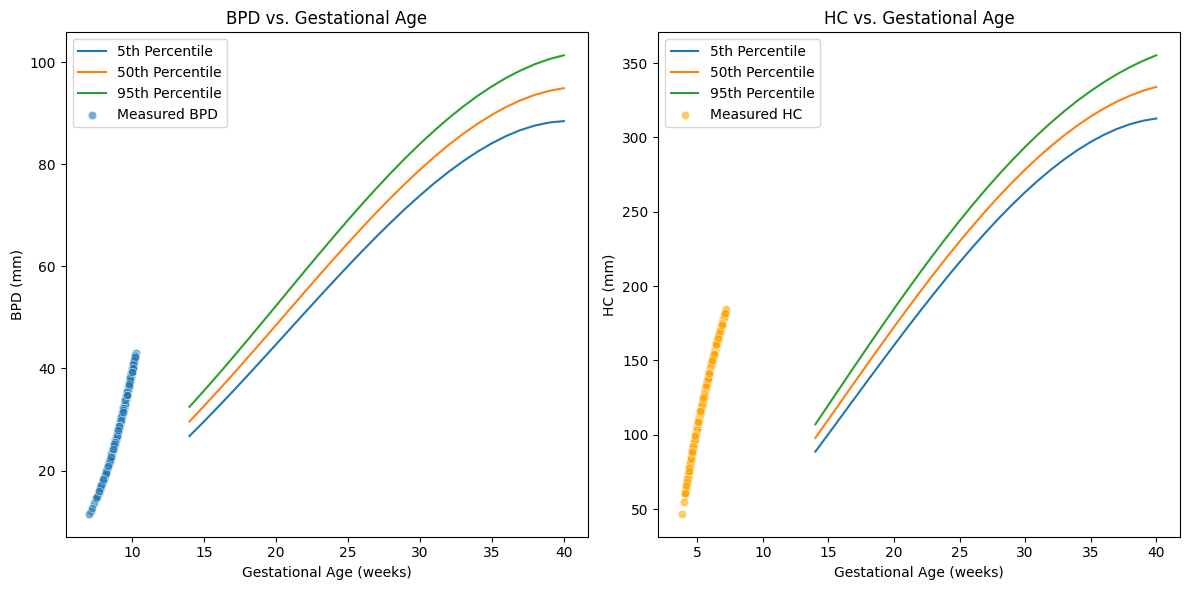

In [138]:
# Plot comparisons
plt.figure(figsize=(12, 6))

# BPD vs GA
plt.subplot(1, 2, 1)
plt.plot(bpd_data.index, bpd_data['5th Percentile'], label='5th Percentile')
plt.plot(bpd_data.index, bpd_data['50th Percentile'], label='50th Percentile')
plt.plot(bpd_data.index, bpd_data['95th Percentile'], label='95th Percentile')
sns.scatterplot(x='GA_BPD', y='BPD_mm', data=df, alpha=0.6, label='Measured BPD')
plt.title("BPD vs. Gestational Age")
plt.xlabel("Gestational Age (weeks)")
plt.ylabel("BPD (mm)")
plt.legend()

# HC vs GA
plt.subplot(1, 2, 2)
plt.plot(hc_data.index, hc_data['5th Percentile'], label='5th Percentile')
plt.plot(hc_data.index, hc_data['50th Percentile'], label='50th Percentile')
plt.plot(hc_data.index, hc_data['95th Percentile'], label='95th Percentile')
sns.scatterplot(x='GA_HC', y='HC_mm', data=df, alpha=0.6, color='orange', label='Measured HC')
plt.title("HC vs. Gestational Age")
plt.xlabel("Gestational Age (weeks)")
plt.ylabel("HC (mm)")
plt.legend()

plt.tight_layout()
plt.show()

In [143]:
hc_data.reset_index(inplace=True)
bpd_data.reset_index(inplace=True)

In [144]:
# Interpolate BPD percentiles
df['BPD_5th'] = np.interp(df['GA_BPD'], bpd_data['Gestational Age'], bpd_data['5th Percentile'])
df['BPD_50th'] = np.interp(df['GA_BPD'], bpd_data['Gestational Age'], bpd_data['50th Percentile'])
df['BPD_95th'] = np.interp(df['GA_BPD'], bpd_data['Gestational Age'], bpd_data['95th Percentile'])

# Interpolate HC percentiles
df['HC_5th'] = np.interp(df['GA_HC'], hc_data['Gestational Age'], hc_data['5th Percentile'])
df['HC_50th'] = np.interp(df['GA_HC'], hc_data['Gestational Age'], hc_data['50th Percentile'])
df['HC_95th'] = np.interp(df['GA_HC'], hc_data['Gestational Age'], hc_data['95th Percentile'])


In [145]:
def classify(value, p5, p95):
    if value < p5:
        return 'Low'
    elif value > p95:
        return 'High'
    else:
        return 'Normal'


In [146]:
df['BPD_Status'] = df.apply(lambda row: classify(row['BPD_mm'], row['BPD_5th'], row['BPD_95th']), axis=1)
df['HC_Status'] = df.apply(lambda row: classify(row['HC_mm'], row['HC_5th'], row['HC_95th']), axis=1)

In [147]:
df.head()

,img_path,annotation_path,radius_px,circumference_px,area_px,circle_center_px,BPD,OFD,HC,HA,...,BPD_flag,HC_flag,BPD_5th,BPD_50th,BPD_95th,HC_5th,HC_50th,HC_95th,BPD_Status,HC_Status
0,/kaggle/input/fetal-head-ultrasound-segmentati...,/kaggle/input/fetal-head-ultrasound-segmentati...,208,1306.902544,135917.86460,"(373, 259)",332.8,416,1657.959582,3964,...,Above 95th,Above 95th,26.75,29.61,32.48,88.69,97.88,107.06,High,High
1,/kaggle/input/fetal-head-ultrasound-segmentati...,/kaggle/input/fetal-head-ultrasound-segmentati...,159,999.026464,79422.60388,"(493, 289)",254.4,318,1525.734184,3648,...,Below 5th,Above 95th,26.75,29.61,32.48,88.69,97.88,107.06,Low,High
2,/kaggle/input/fetal-head-ultrasound-segmentati...,/kaggle/input/fetal-head-ultrasound-segmentati...,213,1338.318470,142530.91710,"(409, 289)",340.8,426,1605.231659,3848,...,Above 95th,Above 95th,26.75,29.61,32.48,88.69,97.88,107.06,High,High
3,/kaggle/input/fetal-head-ultrasound-segmentati...,/kaggle/input/fetal-head-ultrasound-segmentati...,105,659.734457,34636.05901,"(475, 349)",168.0,210,595.813268,1432,...,Below 5th,Below 5th,26.75,29.61,32.48,88.69,97.88,107.06,Low,Low
4,/kaggle/input/fetal-head-ultrasound-segmentati...,/kaggle/input/fetal-head-ultrasound-segmentati...,122,766.548608,46759.46506,"(321, 317)",195.2,244,868.749343,2088,...,Below 5th,Below 5th,26.75,29.61,32.48,88.69,97.88,107.06,Low,Low


In [148]:
df.to_csv('Gestational_Age.csv', index=False)

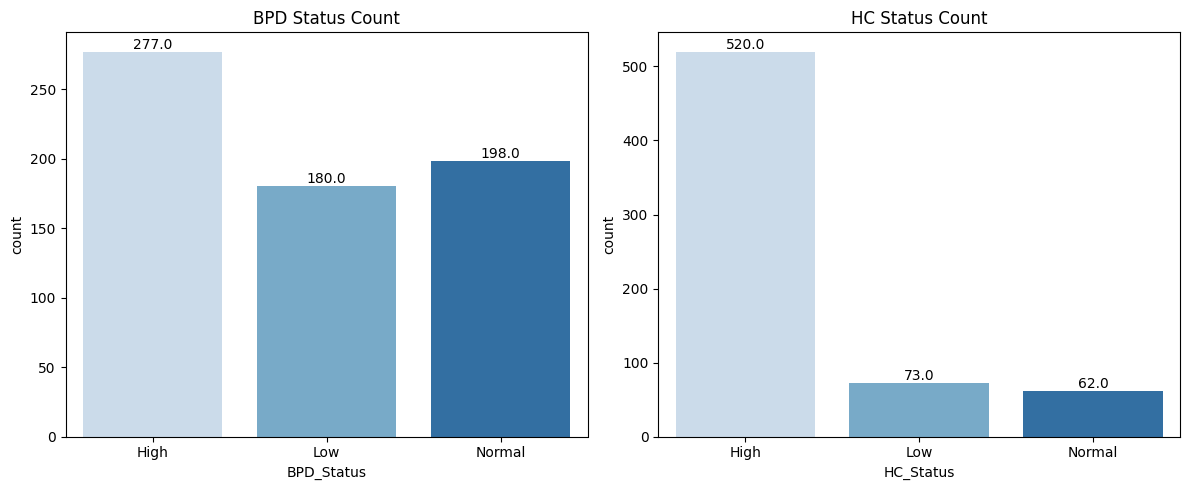

In [162]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Define blue shades
blue_palette = sns.color_palette("Blues", n_colors=3)

# BPD_Status
plt.subplot(1, 2, 1)
ax1 = sns.countplot(x='BPD_Status', data=df, palette=blue_palette)
plt.title('BPD Status Count')

# Add count labels
for p in ax1.patches:
    height = p.get_height()
    ax1.annotate(f'{height}', (p.get_x() + p.get_width() / 2, height),
                 ha='center', va='bottom', fontsize=10)

# HC_Status
plt.subplot(1, 2, 2)
ax2 = sns.countplot(x='HC_Status', data=df, palette=blue_palette)
plt.title('HC Status Count')

# Add count labels
for p in ax2.patches:
    height = p.get_height()
    ax2.annotate(f'{height}', (p.get_x() + p.get_width() / 2, height),
                 ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()
